<a href="https://colab.research.google.com/github/wri-dssg-omdena/policy-data-analyzer/blob/hssc/tasks/fine_tuning_sbert/notebooks/Fine_tuning_SBERT_HSSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning with S-BERT

### Instructions to run this notebook

#### These are the sections in this notebook. Please read the notes below to avoid any errors.

1. [Setup](#setup) - Install the necessary libraries, the GitHub repository, and import the code from the repository.
2. [Data Loading](#data-loading) - Define your **GLOBAL_EXPERIMENT_NUMBER** carefully so that it doesn't overwrite another folder on Google Drive. Running this section will produce the data distriibution for the binary/multiclass classification dataset. A good visual check to see if the number of examples in the classes are roughly equal and well distributes in the training and test datasets. This section also makes sure that the training sentences and labels are available to the Python scripts from the GitHub repository to fine-tune the model.
3. [Configuring W&B credentials and Run](#wandb-config) - The most importany part of this section is to insert your WANDB_API_KEY in the key variable. This will make sure that you can submit your run to the common Weights&Biases project. The WANDB_RUN_GROUP and WANDB_JOB_TYPE variables can be set as well. These 2 variables help in filtering multiple runs of the same or similar hyperparameter configuring for better readability on the Weights&Biases dashboard.
4. [Grid Search Fine Tuning - W&B sweeps](#wandb-sweep) - In this section we define the Weights&Biases hyperparameter sweep. The method of the sweep defines how the automatic tuning will happen (random is the easiest way). If we use the random method, we have to specify the ``count`` parameter later on to tell wandb how many random subsets are to be taken when running the sweep. You can also specify the name of the sweep in this sweep_config. Another important part is to define the maximizing factor, right now in our case it is the ``Weighted F1 validation`` score. **Note**, the maximizing factor in the metrics needs to be a value that we are loggings with wandb (wandb.log), the string needs to match exactly. In the hyperparameter dictionary of the sweep is where we list the multiple values of each hyperparameter that we wish to fine-tune. If the key ``values`` is used, wandb expects a list of values for that hyperparameter, if the key is ``value`` there should only be one value. In this way we can specify constant hyperparameters as well. 
5. [Running training function for only one run](#single-run) - In the scenario where we push to only submit a single run to Weights&Biases, we can use this section to run another training function with **one set of hyperparameter values**. **Note** that this section still requires the WANDB_API_KEY to be set in the [Configuring W&B credentials and Run](#wandb-config) section as well as the run group if it is required.
6. [Removing the saving directory from Google Drive](#delete-folder) - While fine-tuning we save the model in the Google Drive in the GLOBAL_EXPERIMENT_NUMBER folder. After the model is successfully saved onto the Weights&Biases run, we can safely delete the folder from Google Drive to save storage space.
7. [Loading saved model](#load-model) - We can load the model saved in the single run fine-tuning section. The run id is already saved in a variable which is how wandb finds the ``saved_model.pt`` file. If you wish to retrieve a model from a sweep, you need to find the run id from the online dashboard of the best run and use it in this section.
8. [Testing model on test set](#test-set) - In this section we get a realistic performance of the saved model on the test set.

<a name="setup"></a>
## Setup

In [ ]:
# Install necessary libraries
! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  ipywidgets \
  qiskit \
  wandb \
  huggingface-hub==0.0.12 \
  -U sentence-transformers \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg \
  boto3
  # Restarting the runtime is required for the libraries to be active in the notebook
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 112kB 8.7MB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 1.8MB 38.1MB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 624kB 47.8MB/s 
     |████████████████████████████████| 9.1MB 43.2MB/s 
     |████████████████████████████████| 460kB 46.0MB/s 
     |████████████████████████████████| 6.0MB 36.8MB/s 
     |████████████████████████████████| 18.0MB 182kB/s 
     |████████████████████████████████| 235kB 52.3MB/s 
     |████████████████████████████████| 215kB 62.3MB/s 
     |████████████████████████████████| 2.1MB 40.6MB/s 
     |████████████████████████████████| 174kB 52.5MB/s 
     |████████████████████████████████| 133kB 59.7MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 2.5MB 37.8MB/s 
     |████████████████████████████████| 1.2MB 41.3MB

In [1]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Using the GPU


In [2]:
# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Clone branch from github
!rm -rf policy-data-analyzer/
!branch_name='hssc' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 6671, done.
remote: Counting objects: 100% (854/854), done.
remote: Compressing objects: 100% (485/485), done.
remote: Total 6671 (delta 662), reused 518 (delta 367), pack-reused 5817
Receiving objects: 100% (6671/6671), 209.36 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (3778/3778), done.
Checking out files: 100% (1009/1009), done.


In [4]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

In [5]:
import csv
import math
import wandb
import time
import transformers
from pathlib import Path
# import os
import random
import subprocess
from typing import Iterable, Dict

import cupy as cp
# import spacy
import torch
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from torch import nn, Tensor
from torch.utils.data import DataLoader

from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.data_loading.src.utils import *
from tasks.data_visualization.src.plotting import *
from tasks.fine_tuning_sbert.src.custom_evaluator import CustomLabelAccuracyEvaluator
from tasks.model_evaluation.src.model_evaluator import *

In [6]:
class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output

In [11]:
def single_run_fine_tune_HSSC(train_params, train_sents, train_labels, label_names):
    """
    Find the optimal SBERT model by doing a hyperparameter search over random seeds, dev percentage, and different types of SBERT models
    """
    output_path = train_params["output_path"]
    dev_perc = train_params["all_dev_perc"]
    model_name = train_params["model_names"]
    max_num_epochs = train_params["max_num_epochs"]
    group_name = train_params["group_name"]

    print(f"Fine tuning parameters:\n{json.dumps(train_params, indent=4)}")

    # Load base model
    model = SentenceTransformer(model_name)
    # Splitting training and validation datasets
    label2int = dict(zip(label_names, range(len(label_names))))
    X_train, X_dev, y_train, y_dev = train_test_split(train_sents, train_labels, test_size=dev_perc,
                                                      stratify=train_labels, random_state=100)
    print("\n This is the length of the training set:", len(X_train))
    # Load data samples into batches
    train_batch_size = 16
    train_samples = build_data_samples(X_train, label2int, y_train)
    dev_samples = build_data_samples(X_dev, label2int, y_dev)

    # Train set config
    # train_dataset = SentencesDataset(train_samples, model=model)
    train_dataloader = DataLoader(
        train_samples, shuffle=True, batch_size=train_batch_size, num_workers=0,pin_memory=False, generator=torch.Generator(device='cuda'))

    # Dev set config
    # dev_dataset = SentencesDataset(dev_samples, model=model)
    dev_dataloader = DataLoader(
        dev_samples, shuffle=True, batch_size=train_batch_size, num_workers=0,pin_memory=False, generator=torch.Generator(device='cuda'))

    # Define the way the loss is computed
    classifier = SoftmaxClassifier(model=model,
                                   sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                   num_labels=len(label2int))
    warmup_steps = math.ceil(
        len(train_samples) * max_num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up

    # Train the model
    start = time.time()
    dev_evaluator = CustomLabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier,
                                                 name='lae-dev', label_names=label_names)


    model.fit(train_objectives=[(train_dataloader, classifier)],
              evaluator=dev_evaluator,
              epochs=max_num_epochs,
              evaluation_steps=1000,
              warmup_steps=warmup_steps,
              output_path=output_path
              # show_progress_bar=False
              )

    if output_path != None:
        torch.save(model, output_path+'/saved_model.pt')

    return model


def make_dataset_public(train_sents_, train_labels_, label_names_):
    global train_sents, train_labels, label_names
    train_sents = train_sents_
    train_labels = train_labels_
    label_names = label_names_


def build_data_samples(X_train, label2int, y_train):
    train_samples = []
    for sent, label in zip(X_train, y_train):
        label_id = label2int[label]
        train_samples.append(InputExample(texts=[sent], label=label_id))
    return train_samples

def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels, label_names):
    """
    Evaluate an S-BERT model on a previously unseen test set, visualizing the embeddings, confusion matrix,
    and returning. Evaluation method:
     - A sklearn classifier, such as a RandomForest or SVM
    """
    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(
        label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50)
    evaluator.plot_confusion_matrix(color_map='Blues')
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return evaluator.avg_f1.tolist(), evaluator.recall.tolist(), evaluator.precision.tolist()

<a name="data-loading"></a>
## Experiment setup and run

In [8]:
'''
PASTE YOUR WEIGHTS & BIASES KEY HERE
Please do not forget to delete the key after finishing using the notebook. Or simply don't save the notebook to GitHub or Google Drive :)
If the key is compromised you can always make a new one in your W&B settings and remove the old one :)
'''

wandb_key = '44e2528d2a00ca8bd854f7364dca0b21e4b26916'
group_desc = ''
job_type = ''

os.environ['WANDB_JOB_TYPE'] = job_type
os.environ['WANDB_RUN_GROUP'] = group_desc
os.environ['WANDB_API_KEY'] = wandb_key

Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_binary_handpicked"
}

 This is the length of the training set: 448


Evaluating:  12%|█▎        | 1/8 [00:00<00:00,  7.69it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00,  9.13it/s]


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.40it/s]


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.56it/s]


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.83it/s]


Evaluating:  12%|█▎        | 1/8 [00:00<00:00,  7.74it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00,  9.82it/s]


Evaluating:  12%|█▎        | 1/8 [00:00<00:00,  8.60it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00,  9.87it/s]


Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 11.07it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.58it/s]


Evaluating:  12%|█▎        | 1/8 [00:00<00:00,  8.71it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.45it/s]


Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 10.99it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 11.38it/s]


Evaluating:  12%|█▎        | 1/8 [00:00<00:00,  8.74it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 10.90it/s]


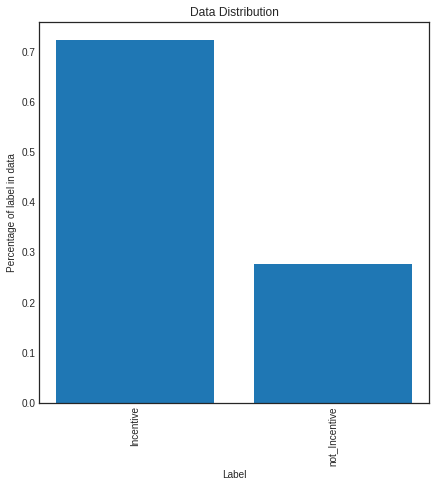

  0%|          | 0/561 [00:00<?, ?it/s]

Label counts:
{'Incentive': 0.723404255319149, 'not_Incentive': 0.2765957446808511}
spanish_binary_handpicked_handpicked

There are 561 elements in the training dataset 
 There are 141 elements in the test set 

Classifying sentences...


100%|██████████| 141/141 [00:02<00:00, 61.26it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.84      0.88      0.86       102
not_Incentive       0.65      0.56      0.60        39

     accuracy                           0.79       141
    macro avg       0.74      0.72      0.73       141
 weighted avg       0.79      0.79      0.79       141



wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Macro/Weighted Avg F1-score: [0.732, 0.79]
\###### [0.732, 0.79] ######

Time taken for fine-tuning: 00:00:18.08


_runtime,231
_timestamp,1625334644
_step,16
Macro F1,0.732
Weighted F1,0.79


_runtime,▁▂▂▃▄▅▅▆▆▇▇██████
_timestamp,▁▂▂▃▄▅▅▆▆▇▇██████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
Macro F1,▁
Weighted F1,▁


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_binary_handpicked"
}

 This is the length of the training set: 883


Evaluating:   7%|▋         | 1/14 [00:00<00:01,  8.88it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.89it/s]


Evaluating:  14%|█▍        | 2/14 [00:00<00:00, 14.87it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.43it/s]


Evaluating:  14%|█▍        | 2/14 [00:00<00:00, 16.29it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 10.87it/s]


Evaluating:  14%|█▍        | 2/14 [00:00<00:00, 16.69it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


Evaluating:   7%|▋         | 1/14 [00:00<00:01,  8.98it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 12.17it/s]


Evaluating:  14%|█▍        | 2/14 [00:00<00:01, 11.03it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.11it/s]


Evaluating:  14%|█▍        | 2/14 [00:00<00:00, 12.80it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.19it/s]


Evaluating:  14%|█▍        | 2/14 [00:00<00:00, 13.99it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.97it/s]


Evaluating:   7%|▋         | 1/14 [00:00<00:01,  9.34it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


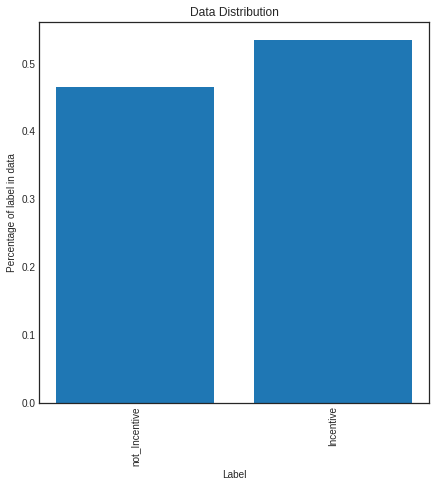

  1%|          | 6/1104 [00:00<00:18, 58.91it/s]

Label counts:
{'not_Incentive': 0.4657039711191336, 'Incentive': 0.5342960288808665}
english_binary_handpicked_handpicked

There are 1104 elements in the training dataset 
 There are 277 elements in the test set 

Classifying sentences...


100%|██████████| 277/277 [00:04<00:00, 61.05it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.84      0.89      0.86       148
not_Incentive       0.87      0.80      0.83       129

     accuracy                           0.85       277
    macro avg       0.85      0.85      0.85       277
 weighted avg       0.85      0.85      0.85       277



wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Macro/Weighted Avg F1-score: [0.847, 0.848]
\###### [0.847, 0.848] ######

Time taken for fine-tuning: 00:00:34.25


_runtime,282
_timestamp,1625334933
_step,16
Macro F1,0.847
Weighted F1,0.848


_runtime,▁▂▃▃▄▄▅▆▆▇▇██████
_timestamp,▁▂▃▃▄▄▅▆▆▇▇██████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
Macro F1,▁
Weighted F1,▁


In [12]:
replica = "3"
base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"
data_path = f"{base_path}/Modeling/Labeled data"
results_save_path = f"{base_path}/Modeling/HSSC/Results/"

project_name = 'HSSC'
languages = ["spanish", "english"]
classification = ["binary"]#, "multiclass"]
labeling = ["handpicked"]#, "assisted", "merged"]


for language in languages:

  for classif_type in classification:
    with open(results_save_path + language + "_" + classif_type + "_" + replica, 'w') as file:
        writer = csv.writer(file)

    for training in labeling:
        for testing in labeling:
            # Setup the WandB group
            group_name = language + "_" + classif_type + "_" + training
            run_name = group_name + "_" + testing
            
            # Init WandB
            wandb.init(project=project_name, name=run_name, group=group_name, entity='jordi_planas')

            # Load training dataset
            train_sents, train_labels = load_training_dataset_HSSC(data_path, language, classif_type, training, "train")
            label_names = unique_labels(train_labels)

            #Model training
            single_run_params = {
                "all_dev_perc": 0.20,
                "model_names": 'paraphrase-xlm-r-multilingual-v1',
                "output_path": results_save_path,
                "max_num_epochs": 10,
                "group_name" : group_name
            }
            model = single_run_fine_tune_HSSC(single_run_params, train_sents, train_labels, label_names)
            results = []
            precision_results = []
            recall_results = []

            start = time.time()

            #Loading testing dataset
            test_sents, test_labels = load_training_dataset_HSSC(data_path, language, classif_type, testing, "test")

            # class balance/imbalance for test set
            label_names_test = unique_labels(test_labels)
            numeric_train_labels_test = labels2numeric(test_labels, label_names_test)
            # print("\n*****", group_name, " -- ", testing, "*****\n")
            class_distribution = plot_data_distribution_HSSC(numeric_train_labels_test, label_names_test)
            wandb.log({"label class distribution": wandb.Image(class_distribution)})
            print(run_name)
            print(f'\nThere are {len(train_labels)} elements in the training dataset \n There are {len(test_labels)} elements in the test set \n')
            #Classification and evaluation
            clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.06,
                                n_jobs=6,
                                random_state=69420)
            F1, recall, precision = evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                            label_names)

            results.append(F1)
            precision_results.append(precision)
            recall_results.append(recall)
            
            wandb.log({"Macro F1": F1[0]})
            wandb.log({"Weighted F1": F1[1]})
            wandb.log({"Precision": precision})
            wandb.log({"Recall": recall})
            
            print("\######", F1, "######\n")
            end = time.time()
            hours, rem = divmod(end - start, 3600)
            minutes, seconds = divmod(rem, 60)
            print("Time taken for fine-tuning:",
                "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))
            
            wandb.run.save()
            wandb.finish()

        with open(results_save_path + language + "_" + classif_type + "_" + replica, 'a') as file:
            writer = csv.writer(file)
            writer.writerow({"Accuracy results": results, "Precision results": precision_results, "Recall results": recall_results})
